In [1]:
%run ../utils.py
%run models.py

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import os
import os.path as osp
import pickle
import matplotlib.pyplot as plt
from cvutils import visualize
from imgaug import augmenters as iaa
from cvutils.keras import generator as keras_generator
from cvutils.augmentation import imgaug as imgaug_utils
import pandas as pd
seed = 8932
plt.gray()
init_session()

train_image_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], 'modeling', 'cytopy', 'datasets', 'kdsb2018', 'stage1_train')
data_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], 'modeling', 'cytopy', 'datasets', 'kdsb2018', 'prep')
#data_file = 'training_data_01.pkl' # crop resizing, point markers
#data_file = 'training_data_02.pkl' # rescale resizing, point markers
data_file = 'training_data_03.pkl' # crop resizing, shrunken markers
model_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], 'modeling', 'cytopy', 'models', 'nuclei', 'v0.1')
model_path = osp.join(model_dir, 'nuclei_model.h5')

In [3]:
with open(osp.join(data_dir, data_file), 'rb') as fd:
    data = pickle.load(fd)

In [4]:
data.keys()

dict_keys(['X', 'class_names', 'index', 'meta', 'Y'])

In [5]:
X, Y, class_names, index, meta = [data[k] for k in ['X', 'Y', 'class_names', 'index', 'meta']]

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype, index.shape

((1752, 256, 256, 1),
 dtype('uint8'),
 (1752, 256, 256, 5),
 dtype('bool'),
 (1752,))

In [7]:
input_shape = X.shape[1:]
input_shape

(256, 256, 1)

In [8]:
class_names

['bg', 'nuc_interior', 'nuc_boundary', 'nuc_partition', 'nuc_center']

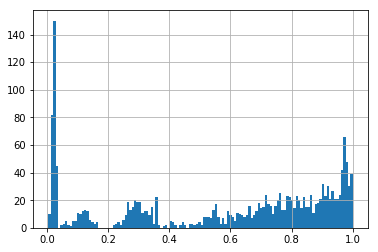

In [9]:
# Determine percent coverage of background in each image
bg_pcts = pd.Series([Y[i, ..., class_names.index('bg')].mean() for i in range(Y.shape[0])])
bg_pcts.hist(bins=128)

In [10]:
bg_mask = ((bg_pcts > .5) & (bg_pcts < 1.)).values
X, Y, index = X[bg_mask], Y[bg_mask], index[bg_mask]
X.shape, Y.shape, index.shape

((1091, 256, 256, 1), (1091, 256, 256, 5), (1091,))

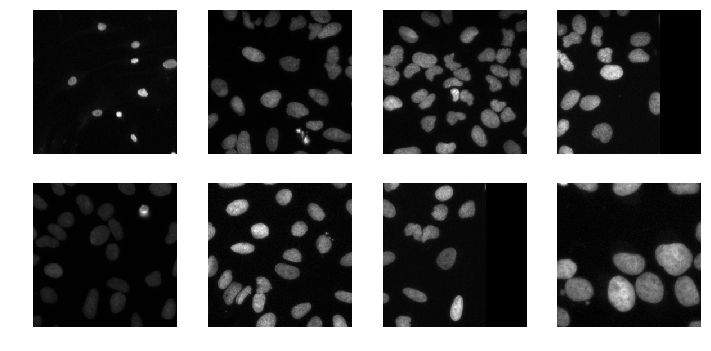

In [11]:
visualize.display_images([X[i, ..., 0] for i in range(0, 8)], size=12)

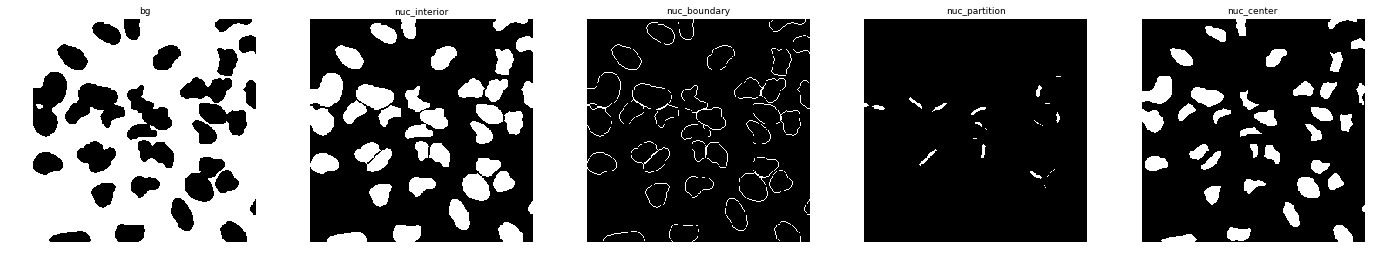

In [12]:
visualize.display_images([Y[2, ..., i] for i in range(Y.shape[-1])], cols=len(class_names), titles=class_names, size=24)

In [13]:
# Determine frequency of positive pixels by mask class
class_freq = np.apply_over_axes(np.mean, Y, axes=[0, 1, 2]).squeeze()
class_freq = pd.Series(dict(zip(class_names, class_freq)))
class_freq

bg               0.816516
nuc_boundary     0.018195
nuc_center       0.071726
nuc_interior     0.118800
nuc_partition    0.002741
dtype: float64

In [14]:
1/class_freq

bg                 1.224715
nuc_boundary      54.960932
nuc_center        13.941878
nuc_interior       8.417475
nuc_partition    364.815250
dtype: float64

In [15]:
# train_classes = ['nuc_interior', 'nuc_boundary', 'nuc_partition', 'nuc_center']
# train_class_wt = [1., 10., 50., 50.]
train_classes = ['nuc_interior', 'nuc_partition', 'nuc_center']

train_class_wt = [1., 40., 5.]

# pos_importance_factor = 50.
# train_class_wt = 1. / class_freq.loc[train_classes]
# train_class_wt /= train_class_wt.sum()
# train_class_wt = (pos_importance_factor * train_class_wt).round(2).tolist()

train_classes_idx = [class_names.index(c) for c in train_classes]
batch_size = 32

assert len(train_class_wt) == len(train_classes)
n_classes = len(train_classes)
Y_target = Y[..., train_classes_idx]
Y.shape, Y_target.shape, train_class_wt

((1091, 256, 256, 5), (1091, 256, 256, 3), [1.0, 40.0, 5.0])

In [16]:
from sklearn.model_selection import train_test_split
idx_train, idx_test = train_test_split(np.arange(X.shape[0]), test_size=.2, random_state=seed)
X_train, X_test, Y_train, Y_test = X[idx_train], X[idx_test], Y_target[idx_train], Y_target[idx_test]

# X_train = X_train[:(batch_size * 5)]
# Y_train = Y_train[:(batch_size * 5)]

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((872, 256, 256, 1),
 (219, 256, 256, 1),
 (872, 256, 256, 3),
 (219, 256, 256, 3))

In [18]:
%run models.py
# w/ sigmoid
model = get_nuclei_model_v1(input_shape)
#opt_conv = {"activation": "relu", "padding": "same", 'kernel_initializer': 'he_normal'}
#model = get_model(n_classes, input_shape, activation='sigmoid', p=[4,5,6,7,8], batch_norm=True, dropout=None, opt_conv=opt_conv)

#model = get_model(n_classes, input_shape, activation='sigmoid', p=[4,5,6,7,8], batch_norm=True, dropout=None)
#model = get_model(n_classes, input_shape, activation='sigmoid', p=[4,5,6,7,8], batch_norm=False, dropout=[.1,.1,.2,.2,.3])
#model = get_model(n_classes, input_shape, activation='sigmoid', p=[4,5,6,7,8], batch_norm=False, dropout=[.1,.1,.2,.2,.3])

#model = get_model(n_classes, input_shape, activation='sigmoid', p=[6,7,8,9], batch_norm=True, dropout=None)

In [19]:
#model.summary()

In [20]:
def weighted_pixelwise_crossentropy(weights):
    """Get pixel-weighted sigmoid cross entropy loss"""
    
    # Assume that weights could cover any dimension after the 
    # batch dimension (i.e. the first one) -- from there, it
    # should simply be broadcastable to the dimensions of a single
    # prediction/label (which for images may be 3D)
    w = np.array([weights])
    
    # Make sure weights are now 4D
    assert w.ndim == 4
    
    def loss(y_true, y_pred):
        _epsilon = 10e-8
        y_pred = tf.clip_by_value(y_pred, _epsilon, 1. - _epsilon)
        return - tf.reduce_mean(y_true * w *  tf.log(y_pred) + (1 - y_true)  *  tf.log(1 - y_pred))
    return loss

loss = weighted_pixelwise_crossentropy([[train_class_wt]])

In [21]:
optimizer = keras.optimizers.RMSprop(lr=1e-4)
metrics = [keras.metrics.binary_accuracy]
for i, c in enumerate(train_classes):
    metrics.append(binary_channel_precision(i, c, min_p=.6))
model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

In [34]:
import imgaug as ia


secondary_augmentations = [
    # Blur 
    iaa.OneOf([
        iaa.GaussianBlur(sigma=(0, 1.5)), 
        iaa.AverageBlur(k=(3, 7)), 
        iaa.MedianBlur(k=(3, 7))
    ]),
    
    # Noise
    iaa.AdditiveGaussianNoise(scale=(0., 10.)),
    
    # Randomly alter distribution
    iaa.OneOf([iaa.Multiply((.5, 2.)), iaa.Add((-50, 50))])
]

seq = iaa.Sequential([
    
    iaa.Fliplr(.25),
    iaa.Flipud(.25),
    
    # Crop images by -5% to 10% of their height/width
    sometimes(iaa.CropAndPad(
        percent=(-0.05, 0.1),
        pad_mode=ia.ALL,
        pad_cval=(0, 255)
    ), p=.3),
    
    # Rotations, scaling and shearing
    sometimes(iaa.Affine(
        rotate=(0., 30.), 
        scale={"x": (.8, 1.2), "y": (.8, 1.2)}, 
        shear=(-16, 16), 
        order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
        cval=(0, 255), # if mode is constant, use a cval between 0 and 255
        mode=ia.ALL
    ), p=.3),
    
    iaa.SomeOf((0, 3), secondary_augmentations)
    
], random_order=False, random_state=seed)

In [36]:
#visualize_augmentation(list(load_images(train_image_dir).values())[0], seq, 11, cols=4, size=20)

In [37]:
from skimage import img_as_float32

def get_loader(X, Y, augmentation=None):
    assert len(X) == len(Y)
    ids = np.arange(len(X))
    def load(sample_id):
        image, mask = X[sample_id], Y[sample_id]
        
        # Ensure data types on input
        assert image.dtype == np.uint8
        assert mask.dtype == np.bool
        
        if augmentation is not None:
            image, mask = imgaug_utils.apply_augmentation(image, mask, augmentation)
        
        # Now convert everything to floats in [0, 1] for training
        image = img_as_float32(image)
        assert image.min() >= 0 and image.max() <= 1, \
            'Expecting image range in [0, 1] but got [{}, {}]'.format(img.min(), img.max())
        mask = mask.astype(np.float32)
        
        return image, mask
    return ids, load

In [38]:
train_ids, train_loader = get_loader(X_train, Y_train, augmentation=seq)
#train_ids, train_loader = get_loader(X_train, Y_train, augmentation=None)
train_generator = keras_generator.BaseDataGenerator(train_ids, train_loader, batch_size=batch_size, shuffle=True)

test_ids, test_loader = get_loader(X_test, Y_test, augmentation=None)
test_generator = keras_generator.BaseDataGenerator(test_ids, test_loader, batch_size=batch_size, shuffle=True)

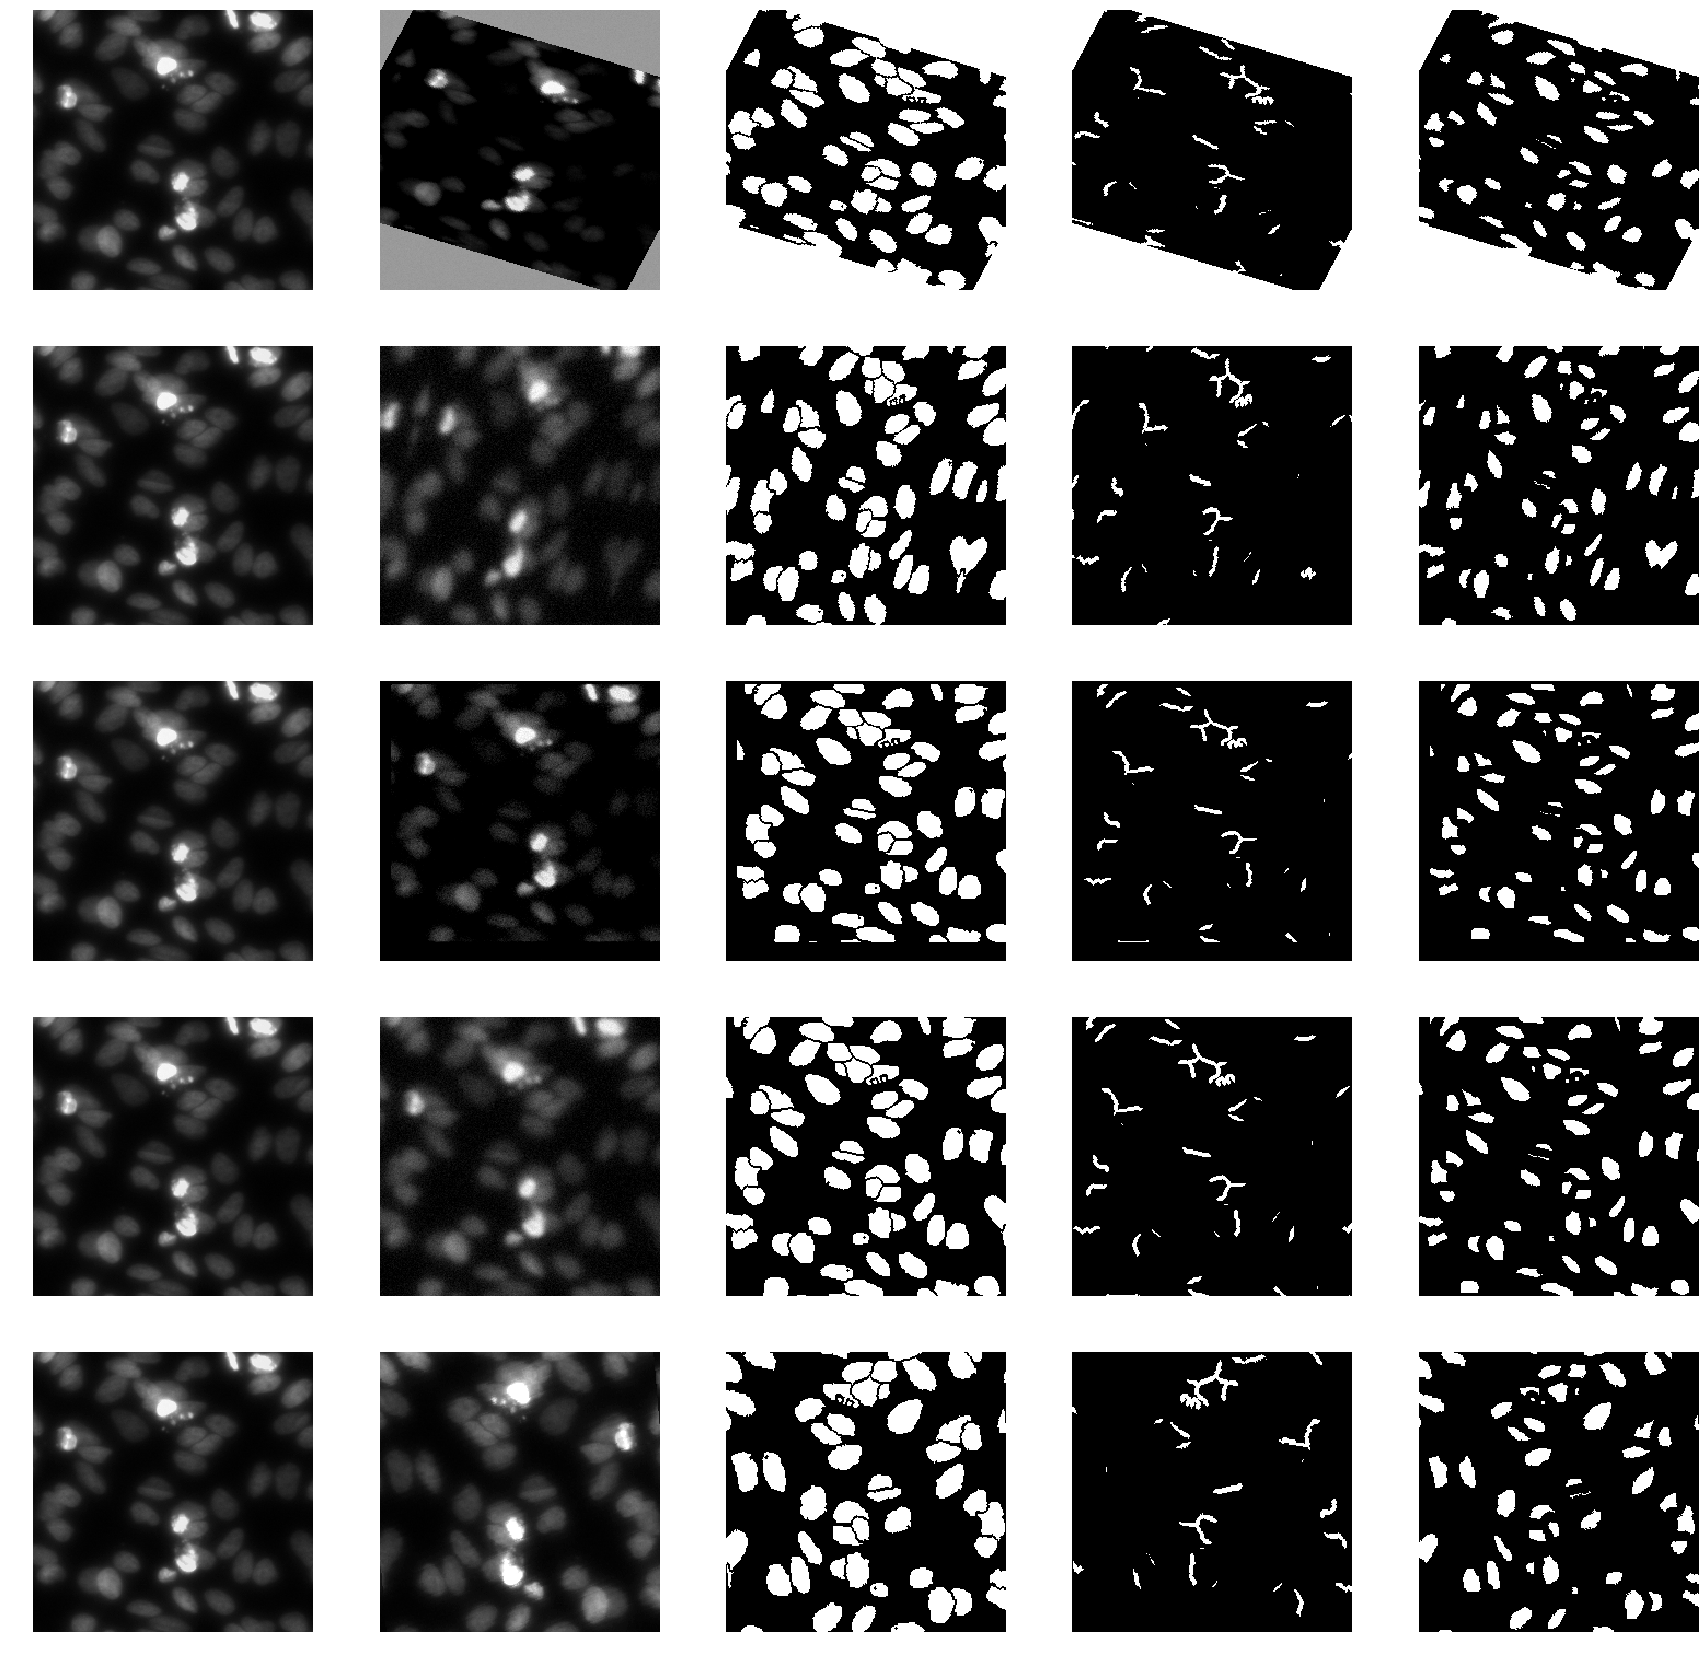

In [39]:
ex_aug = 'ex2'
visualize_segmentation_augmentation(
    X[index == DEFAULT_IDS[ex_aug]][0],
    Y_target[index == DEFAULT_IDS[ex_aug]][0],
    seq, n=5, size=30
)

In [40]:
!rm $model_dir/* || true

callbacks = [
    keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss', mode='min', verbose=0, 
        save_best_only=True, save_weights_only=False, period=1
    ), 
    keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='min'), 
    keras.callbacks.TensorBoard(log_dir=model_dir)
]

history = model.fit_generator(
    train_generator, 
    epochs=75,
    #steps_per_epoch=15,
    callbacks=callbacks,
    validation_data=test_generator
)

Epoch 1/75
27/27 [==============================] - 13s 475ms/step - loss: 1.0601 - binary_accuracy: 0.4778 - nuc_interior: 0.1970 - nuc_partition: 0.0365 - nuc_center: 0.0952 - val_loss: 0.8750 - val_binary_accuracy: 0.5654 - val_nuc_interior: 0.2851 - val_nuc_partition: 0.0044 - val_nuc_center: 0.1942
Epoch 2/75
27/27 [==============================] - 8s 290ms/step - loss: 0.9434 - binary_accuracy: 0.5546 - nuc_interior: 0.3343 - nuc_partition: 0.0718 - nuc_center: 0.1860 - val_loss: 0.8003 - val_binary_accuracy: 0.6825 - val_nuc_interior: 0.5340 - val_nuc_partition: 0.0097 - val_nuc_center: 0.3055
Epoch 3/75
27/27 [==============================] - 9s 334ms/step - loss: 0.8929 - binary_accuracy: 0.6248 - nuc_interior: 0.4905 - nuc_partition: 0.0981 - nuc_center: 0.2552 - val_loss: 0.7739 - val_binary_accuracy: 0.7243 - val_nuc_interior: 0.6989 - val_nuc_partition: 0.0107 - val_nuc_center: 0.3673
Epoch 4/75
27/27 [==============================] - 9s 343ms/step - loss: 0.8438 - bina

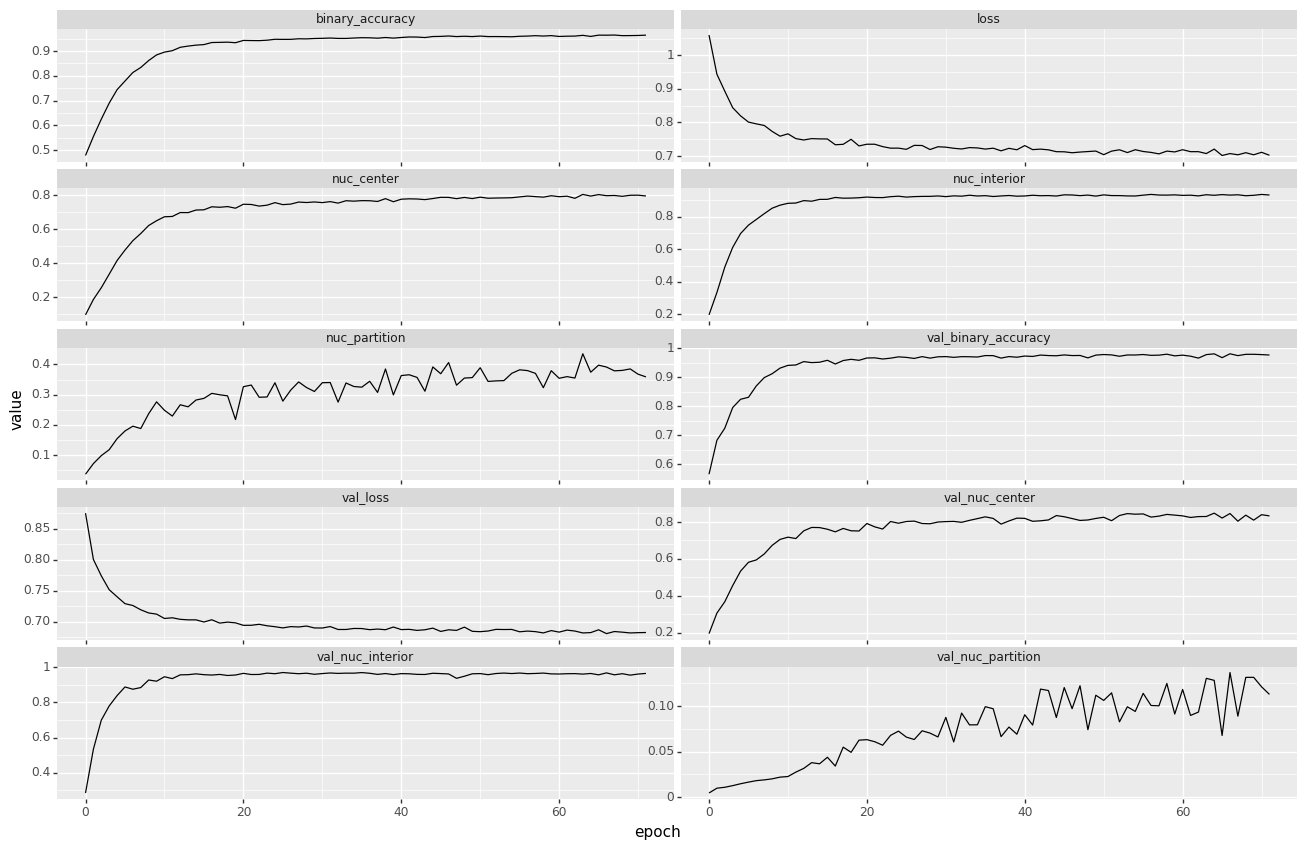

<ggplot: (8749210409529)>

In [41]:
plot_model_history(history.history, window=slice(None, None))

In [42]:
pred_model = model

In [50]:
def inference_data(ids):
    mask = np.in1d(index, ids)
    Xi, Yi = X[mask], Y_target[mask]
    inf_ids, l = get_loader(Xi, Yi, augmentation=None)
    gen = keras_generator.BaseDataGenerator(inf_ids, l, batch_size=len(Xi), shuffle=False)
    return gen[0]

inf_ids = [
    'a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288',
    '0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1',
    '07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5',
    '20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f',
    '5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3',
    '8efed2e62c919e6d70a2ab548b1a33014877fe8a23f177ef25a9dee25ffe8842',
    '547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3cfa6576f24c631a7ae6',
    'c304a1fdf3bca2f4b4580d2cac59942e2224a7678001bf5ed9d9852f57708932',
    'cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490',
    '6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee5622'
]
X_pred, Y_true = inference_data(inf_ids)
X_pred.shape, Y_true.shape

((63, 256, 256, 1), (63, 256, 256, 3))

In [44]:
#pred_batch = train_batches
X_pred, Y_true = test_generator[1]
#X_pred, Y_true = train_generator[0]

In [51]:
Y_pred = pred_model.predict(X_pred)

In [52]:
X_pred.shape, Y_pred.shape, Y_true.shape

((63, 256, 256, 1), (63, 256, 256, 3), (63, 256, 256, 3))

In [53]:
Y_pred.min(), Y_pred.max()

(0.5, 0.9999497)

In [294]:
# plt.hist(Y_pred.ravel(), bins=248)
# ax = plt.gca()
# ax.set_yscale('symlog')
# None

In [48]:
train_classes

['nuc_interior', 'nuc_partition', 'nuc_center']

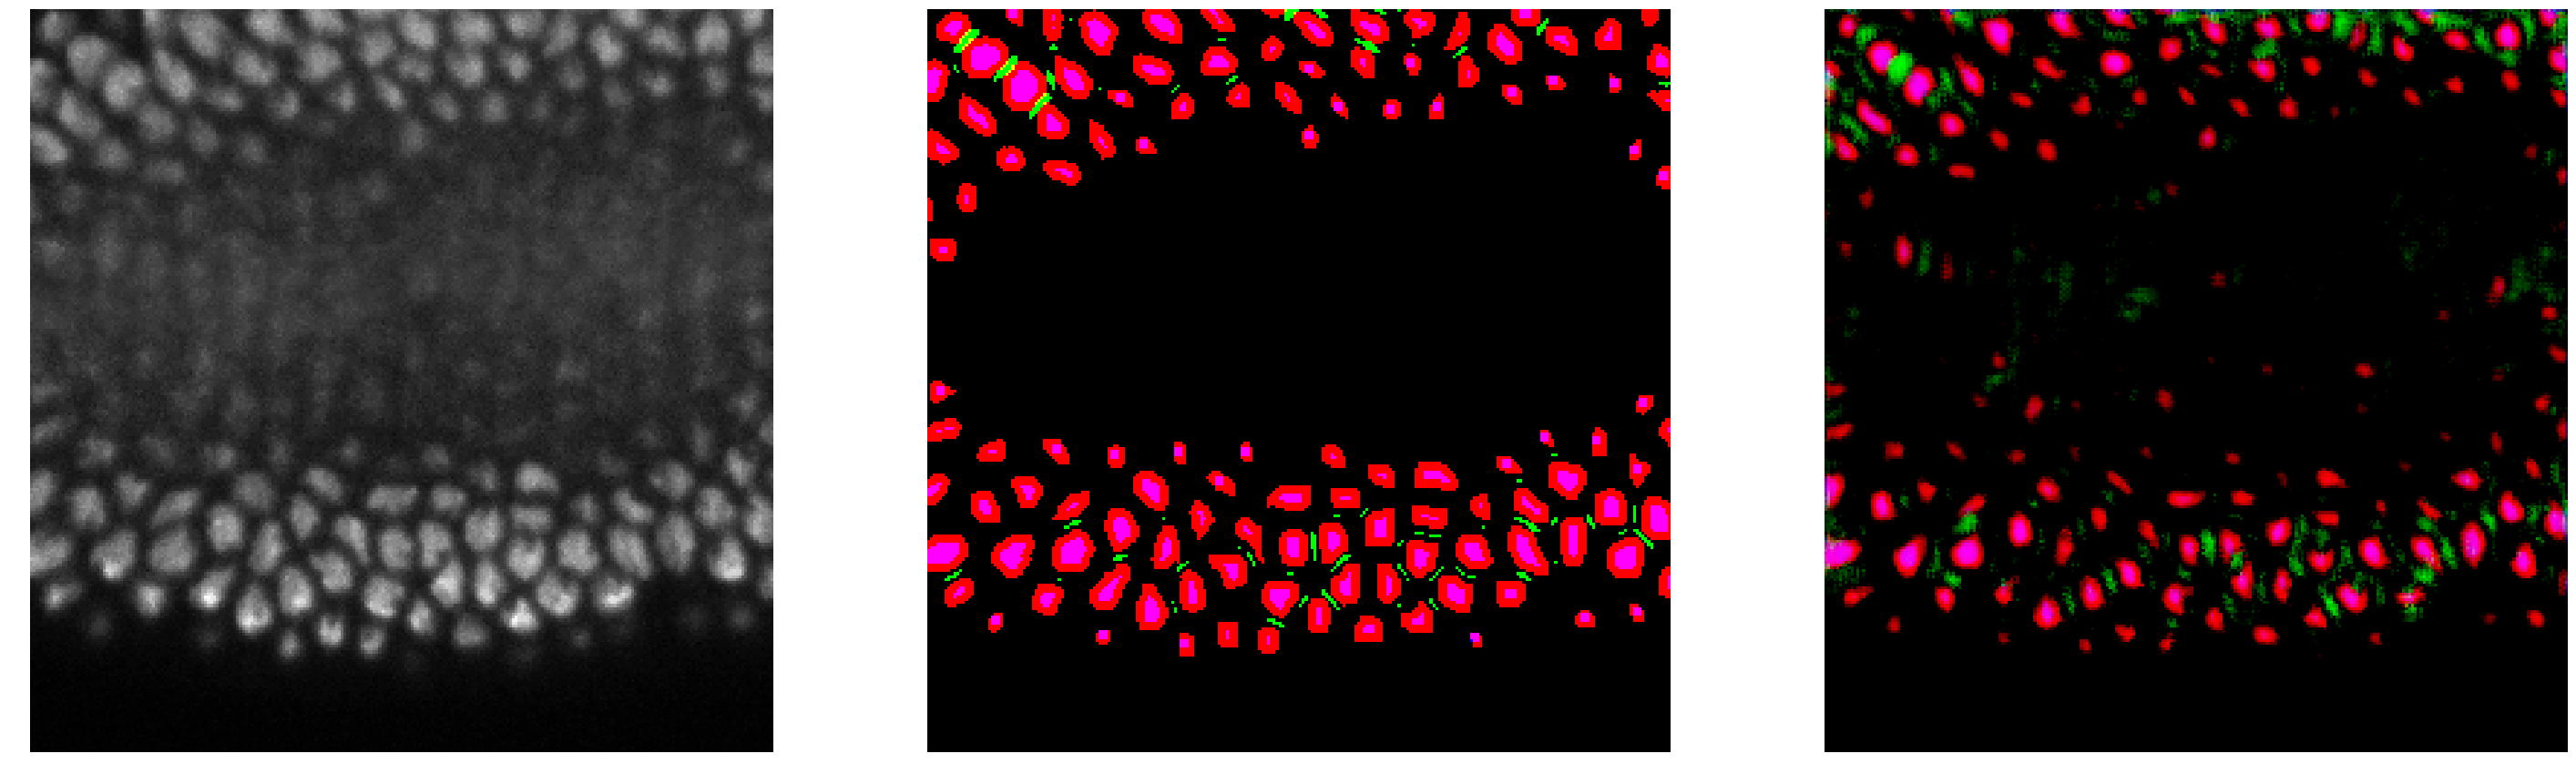

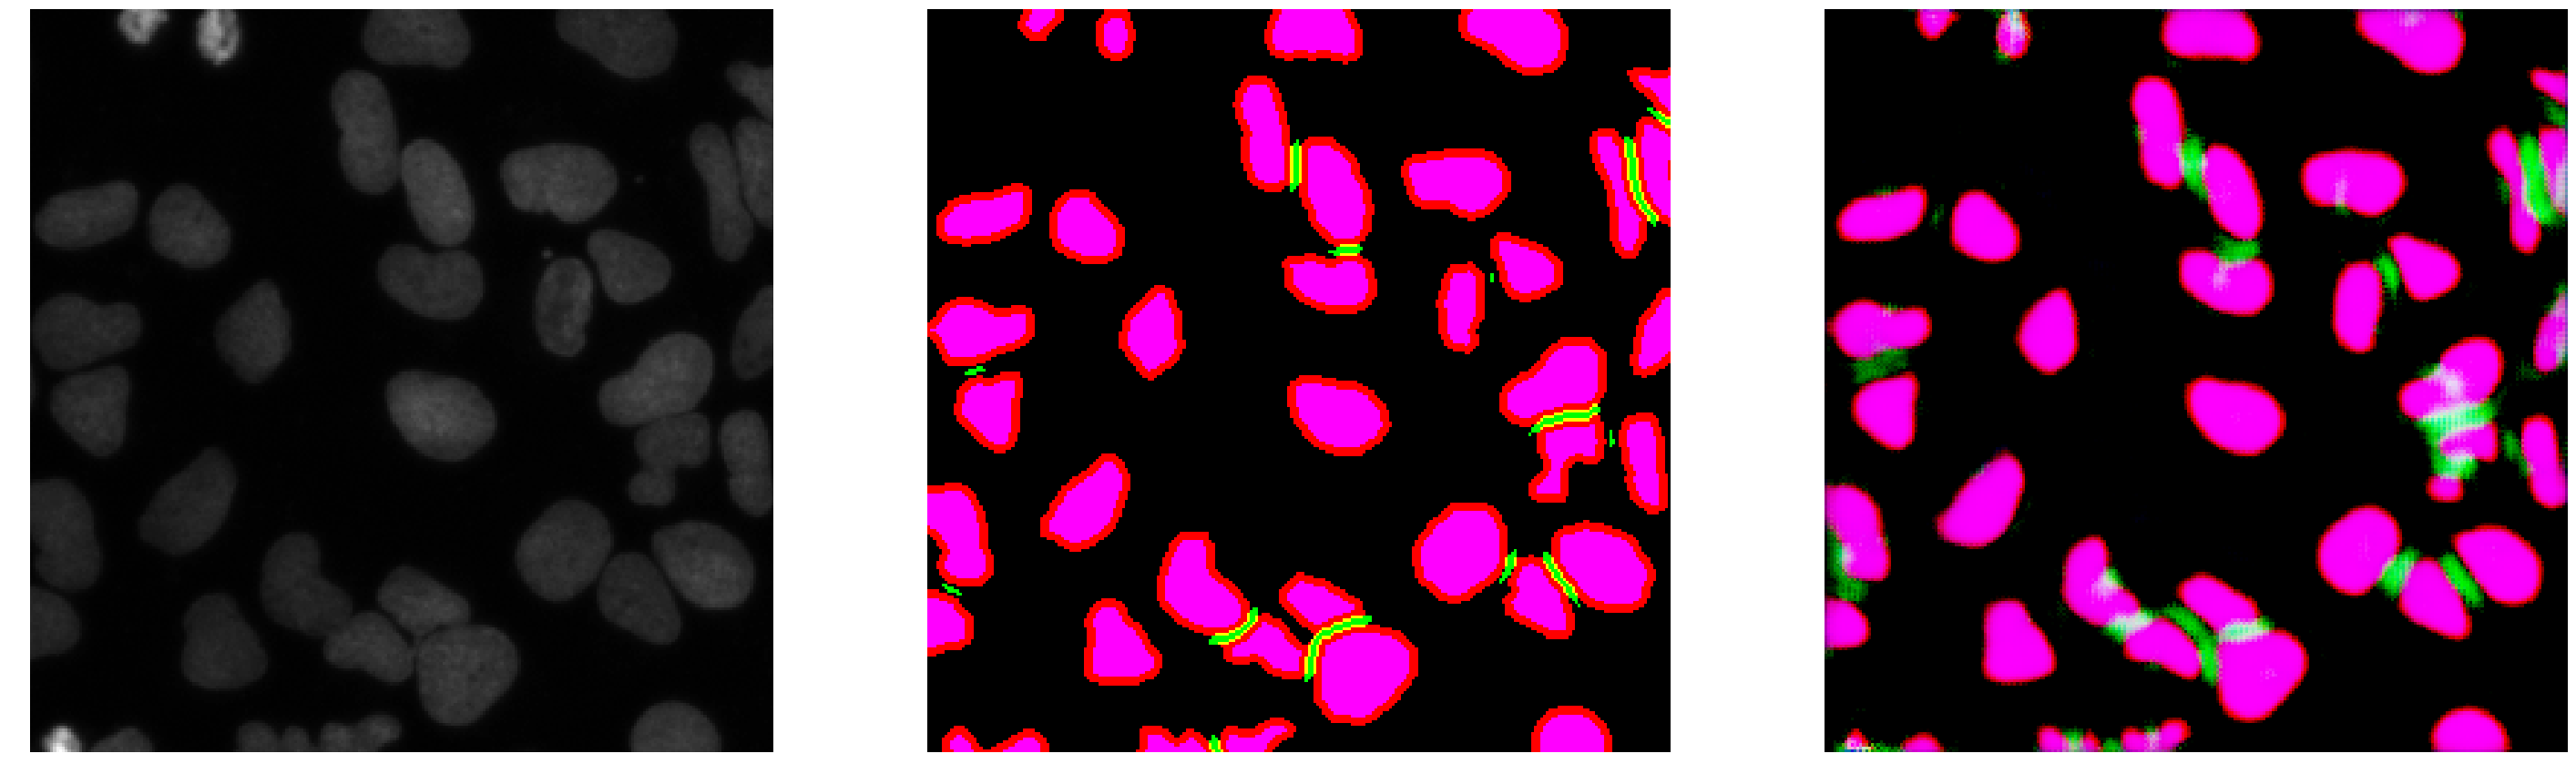

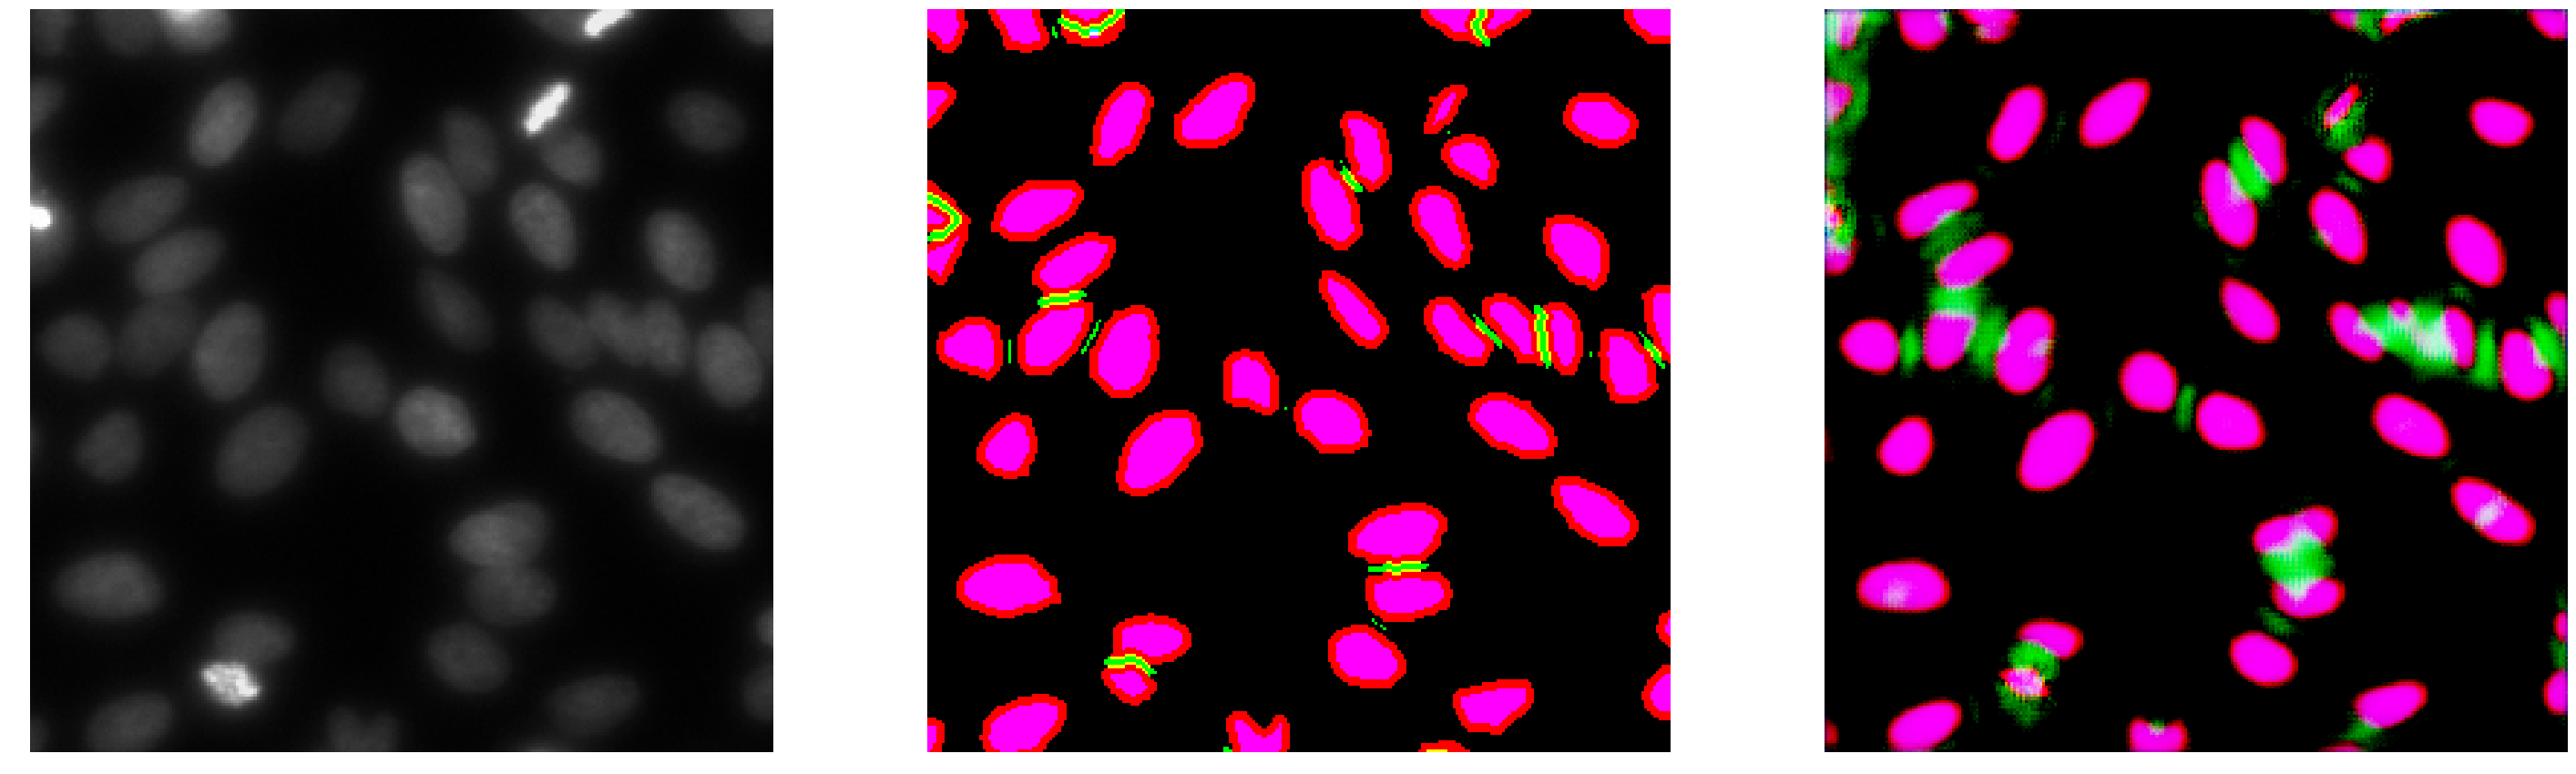

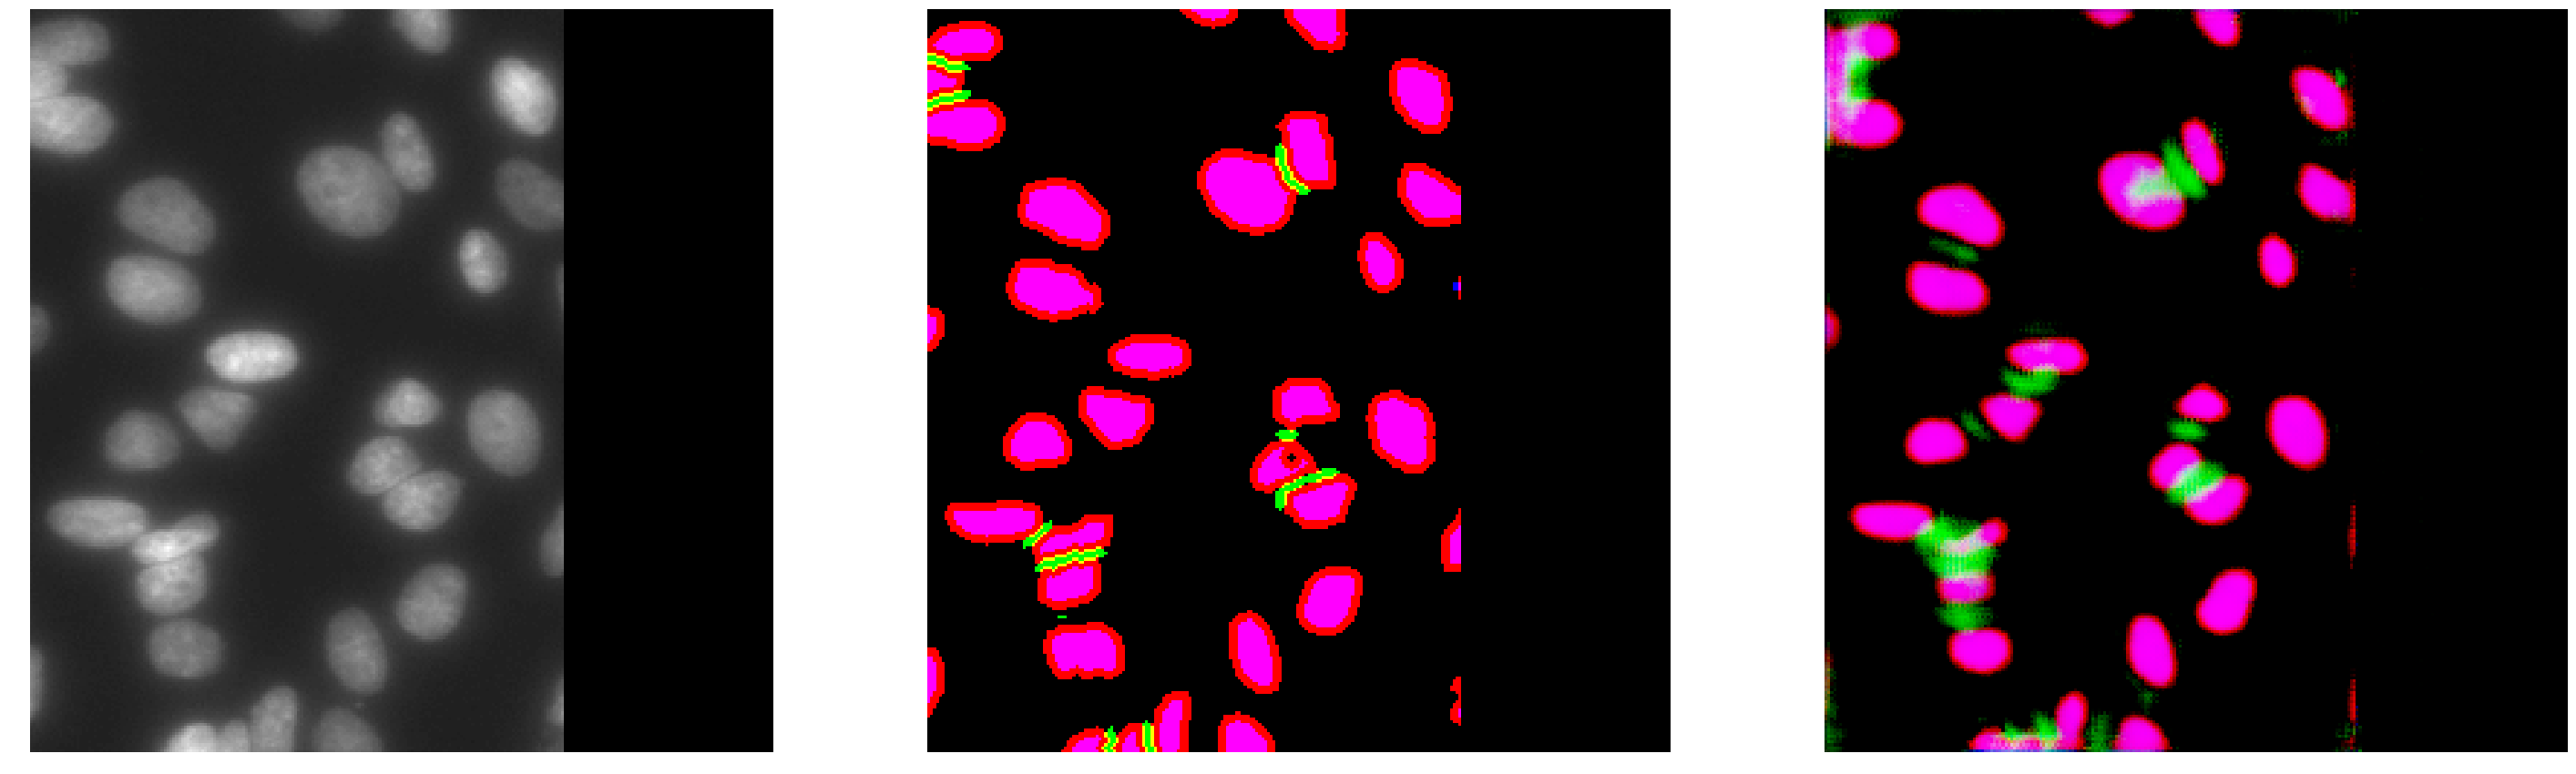

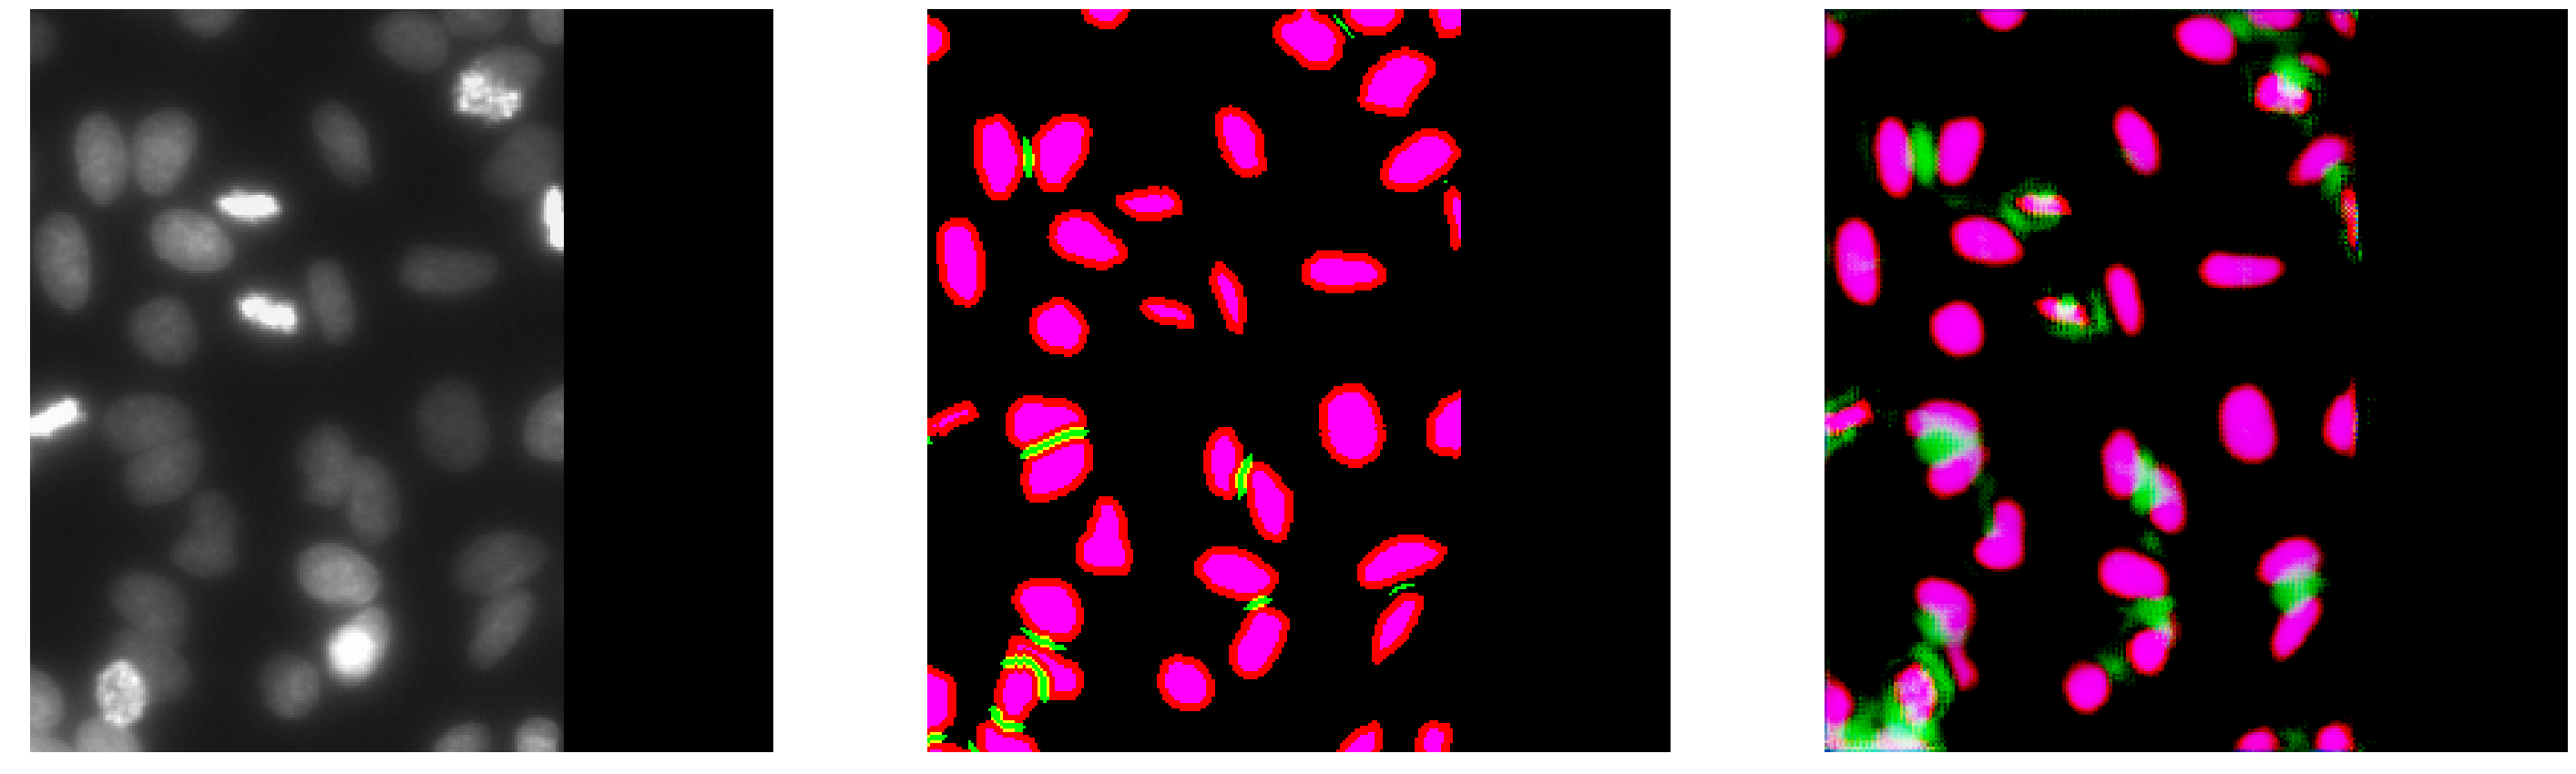

In [54]:
from skimage import exposure
y_chs = [0, 1, 2]
assert len(y_chs) == 3
viz_idx = np.random.choice(np.arange(len(X_pred)), replace=False, size=min(5, len(X_pred)))
#viz_idx = [0, 1, 2, 3, 4, 5]
#viz_idx = [0, 1, 2]
for i in viz_idx:
    images = []
    images += [X_pred[i, ..., 0]]
    images += [exposure.rescale_intensity(Y_true[i][..., y_chs], out_range=np.uint8).astype(np.uint8)]
    images += [np.stack([
        exposure.rescale_intensity(Y_pred[i][..., yi], out_range=np.uint8).astype(np.uint8)
        for yi in y_chs
    ], -1)]
    visualize.display_images(images, size=50, cols=3)

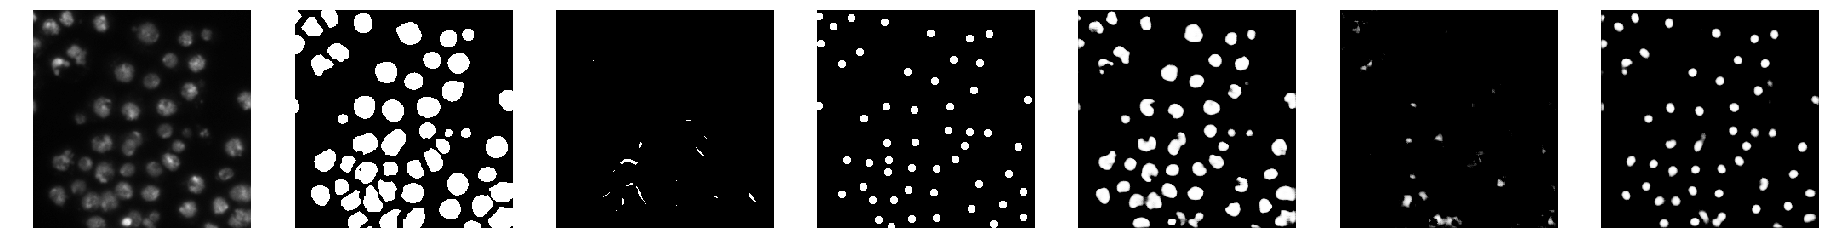

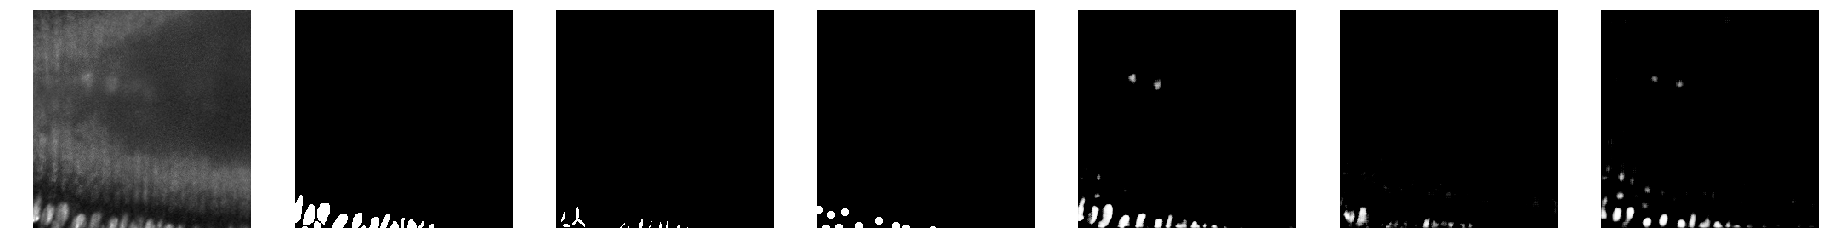

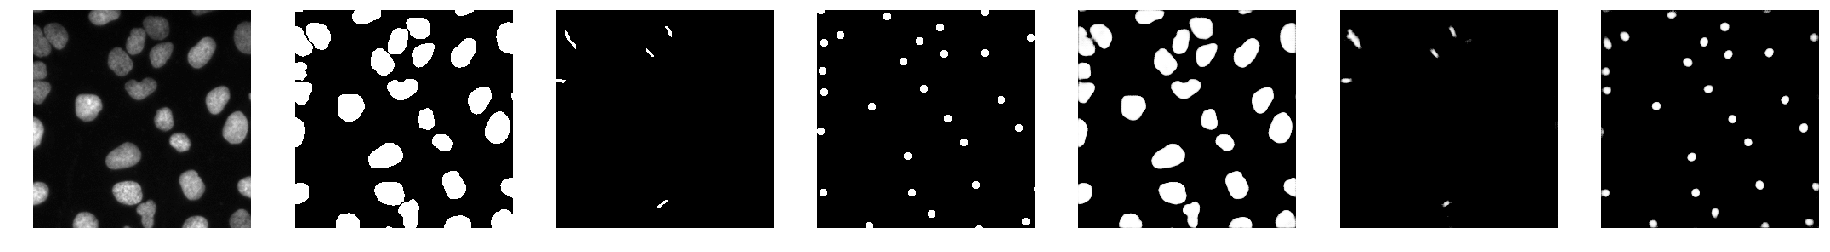

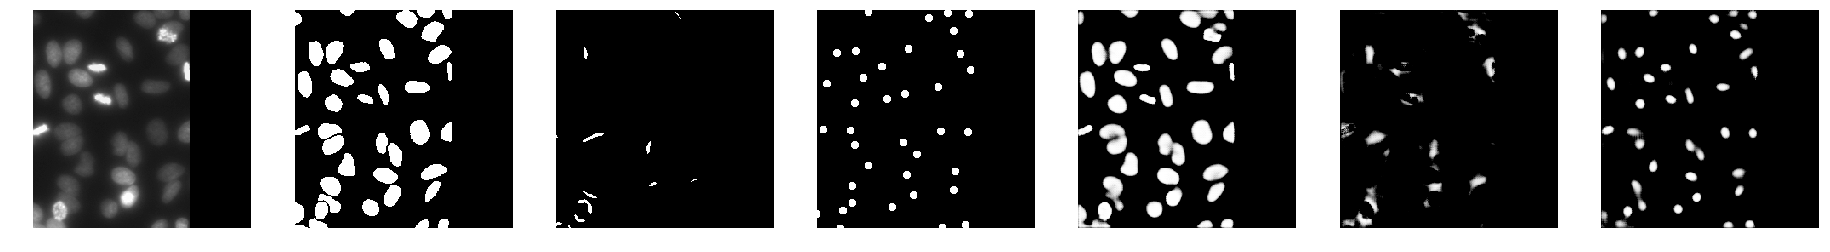

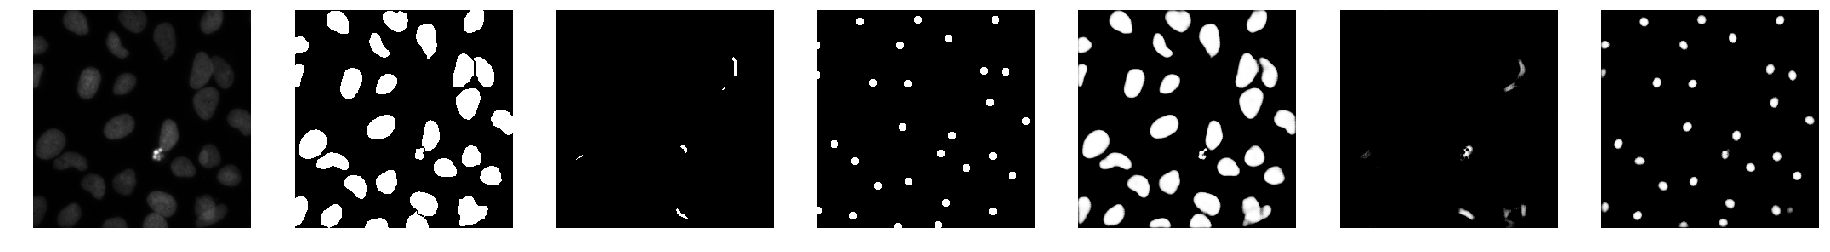

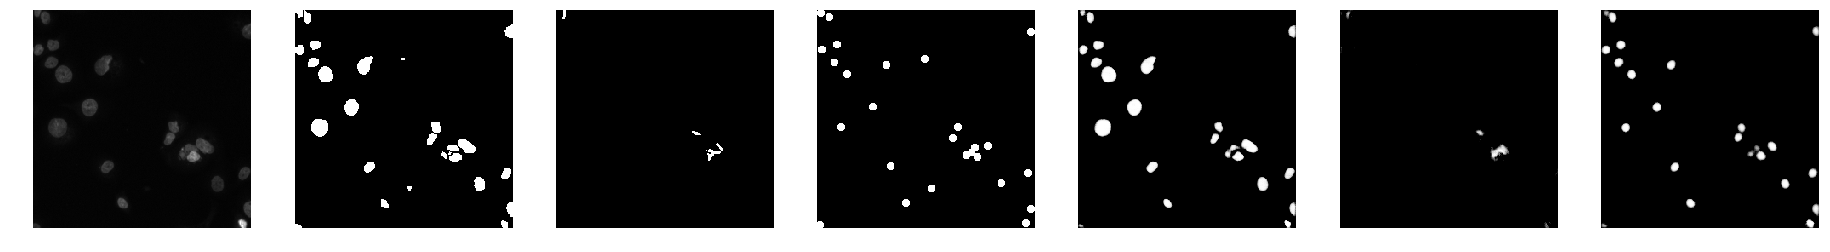

In [104]:
y_chs = [0, 1, 2]
for i in [0, 1, 2, 3, 4, 5]:
    images = []
    images += [X_pred[i, ..., 0]]
    images += [Y_true[i, ..., ch] for ch in y_chs]
    images += [Y_pred[i, ..., ch] for ch in y_chs]
    visualize.display_images(images, size=32, cols=2*len(y_chs)+1)